In [1]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD

from matplotlib import pyplot
import matplotlib.pyplot as plt

In [2]:
!pip install keras_tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.2 MB/s eta 0:00:00


In [3]:
batch_size=128
num_classes=10
epochs=20

In [4]:
(xtrain,ytrain),(xtest,ytest)=mnist.load_data()
print('Shape-x:\t',xtrain.shape)
print('Shape-y:\t',ytrain.shape)

11490434/11490434 [==============================] - 0s 0us/step
Shape-x:	 (60000, 28, 28)
Shape-y:	 (60000,)


In [6]:
xtrain=xtrain.reshape(60000,784)
xtest=xtest.reshape(10000,784)
print('Shape-x-train:\t',xtrain.shape)
print('Shape-x-Test:\t',xtest.shape)

Shape-x-train:	 (60000, 784)
Shape-x-Test:	 (10000, 784)


In [7]:
xtrain=xtrain.astype('float32')
xtest=xtest.astype('float32')

In [8]:
xtrain=xtrain/255.
xtest=xtest/255.

In [9]:
import keras
ytrain=keras.utils.to_categorical(ytrain,num_classes)
ytest=keras.utils.to_categorical(ytest,num_classes)

In [10]:
model=Sequential()
model.add(Dense(512,activation='relu',input_shape=(784,)))
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes,activation='softmax'))

optm=SGD(learning_rate=0.01,momentum=0.9)

model.compile(loss='binary_crossentropy',optimizer=optm,metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 671754 (2.56 MB)
Trainable params: 670730 (2.56 MB)
Non-trainable params: 1024 (4.00 KB)
_________________________________________________________________


In [12]:
history=model.fit(xtrain,ytrain,validation_data=(xtest,ytest),epochs=20,verbose=1)

Epoch 1/20
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0845 - accuracy: 0.9218 - val_loss: 0.0301 - val_accuracy: 0.9603
Epoch 2/20
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0277 - accuracy: 0.9640 - val_loss: 0.0217 - val_accuracy: 0.9686
Epoch 3/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0198 - accuracy: 0.9757 - val_loss: 0.0179 - val_accuracy: 0.9748
Epoch 4/20
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0154 - accuracy: 0.9818 - val_loss: 0.0154 - val_accuracy: 0.9789
Epoch 5/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0124 - accuracy: 0.9860 - val_loss: 0.0148 - val_accuracy: 0.9802
Epoch 6/20
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0100 - accuracy: 0.9894 - val_loss: 0.0139 - val_accuracy: 0.9792
Epoch 7/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0083 - accuracy: 0.9919 - val_loss: 0.0134 -

In [13]:
_,train_acc=model.evaluate(xtrain,ytrain,verbose=1)
_,test_acc=model.evaluate(xtest,ytest,verbose=1)
print('Train Accuracy:\t',train_acc)
print()
print('Test Accuracy:\t',test_acc)

313/313 [==============================] - 2s 6ms/step - loss: 0.0117 - accuracy: 0.9839
Train Accuracy:	 0.9999833106994629

Test Accuracy:	 0.9839000105857849


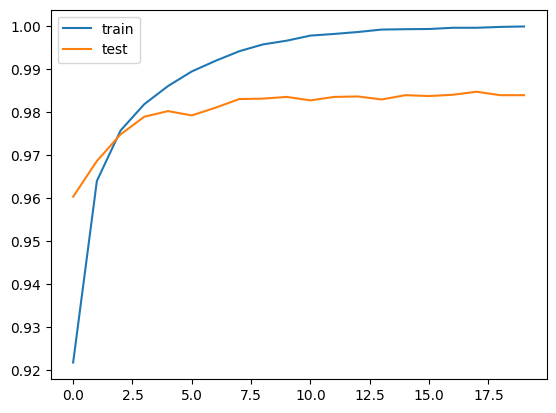

In [14]:
pyplot.plot(history.history['accuracy'],label='train')
pyplot.plot(history.history['val_accuracy'],label='test')
pyplot.legend()
pyplot.show()

In [15]:
import keras_tuner
from kerastuner.tuners import Hyperband

<ipython-input-15-8b140884954f>:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.engine.hyperparameters import HyperParameter

In [17]:
# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Define the model-building function
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))

    # Tune the number of hidden layers and units
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Dense(units=hp.Int(f'units_{i}', 32, 128, step=32), activation='relu'))
        model.add(layers.Dropout(0.2))

    model.add(layers.Dense(10, activation='softmax'))

    # Compile the model with a tunable learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Instantiate the tuner and perform hyperparameter tuning
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='keras_tuner_dir',
    project_name='mnist_hyperband'
)

tuner.search(x_train, y_train, epochs=10, validation_data=(x_test,y_test))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
best_model.fit(x_train, y_train, epochs=10, validation_data=(x_test,y_test))

Trial 30 Complete [00h 01m 32s]
val_accuracy: 0.9463000297546387

Best val_accuracy So Far: 0.9805999994277954
Total elapsed time: 00h 20m 20s
Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2981 - accuracy: 0.9134 - val_loss: 0.1452 - val_accuracy: 0.9562
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1441 - accuracy: 0.9571 - val_loss: 0.1029 - val_accuracy: 0.9674
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1088 - accuracy: 0.9668 - val_loss: 0.0901 - val_accuracy: 0.9726
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0893 - accuracy: 0.9724 - val_loss: 0.0727 - val_accuracy: 0.9767
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0765 - accuracy: 0.9755 - val_loss: 0.0739 - val_accuracy: 0.9771
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0644 - accuracy: 0.9798 - val_loss: 0.0716 - val_accuracy